# Image Resconstrute

- Reference : 

1. https://arxiv.org/pdf/2111.12417v1.pdf
2. https://arxiv.org/pdf/2212.06714.pdf

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers
from tensorflow import keras

from transformers import ViTModel

from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import visualkeras
import cv2
import os

In [ ]:
np.random.seed(42)

# Load Dataset

In [ ]:
X_DATA_PATH = "./data/gaussian/cropped/"
Y_DATA_PATH = "./data/gaussian/resized/"
NOISE_Y_DATA_PATH = "./only_noise/"

x_data_path_list = os.listdir(X_DATA_PATH)
y_data_path_list = os.listdir(Y_DATA_PATH)
y_noise_data_path_list = os.listdir(NOISE_Y_DATA_PATH)

X, y, y_noise = list(), list(), list()
for x_data_path in tqdm(x_data_path_list, desc=f'X data loading...'):   X.append(cv2.imread(X_DATA_PATH + x_data_path))
for y_data_path in tqdm(y_data_path_list, desc=f'Y data loading...'):   y.append(cv2.imread(Y_DATA_PATH + y_data_path))
for y_noise_data_path in tqdm(y_noise_data_path_list, desc=f'Y noise data loading...'):   y_noise.append(cv2.imread(NOISE_Y_DATA_PATH + y_noise_data_path))

Y noise data loading...: 100%|██████████| 5000/5000 [00:05<00:00, 953.76it/s]


In [ ]:
DATA_COUNT = 400

X = np.array(X)[:DATA_COUNT,:,:,0]
y = np.array(y)[:DATA_COUNT,:,:,0]
y_noise = np.array(y_noise)[:DATA_COUNT,:,:,0]

scaler = MinMaxScaler()
X = scaler.fit_transform(X.reshape(-1, 1)).reshape(X.shape)
y = scaler.fit_transform(y.reshape(-1, 1)).reshape(y.shape)
y_noise = scaler.fit_transform(y_noise.reshape(-1, 1)).reshape(y_noise.shape)

print(f"""X shape: {X.shape}
y shape: {y.shape}
y_noise shape: {y_noise.shape}""")

X shape: (400, 256, 256)
y shape: (400, 256, 256)
y_noise shape: (400, 256, 256)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"""X_train shape: {X_train.shape}
y_train shape: {y_train.shape}
X_test shape: {X_test.shape}
y_test shape: {y_test.shape}""")

X_train shape: (320, 256, 256)
y_train shape: (320, 256, 256)
X_test shape: (80, 256, 256)
y_test shape: (80, 256, 256)


In [ ]:
_, _, y_train_noise, y_test_noise = train_test_split(y_noise, y_noise, test_size=0.2, random_state=42)
print(f"""y_train shape: {y_train_noise.shape}
y_test shape: {y_test_noise.shape}""")

y_train shape: (320, 256, 256)
y_test shape: (80, 256, 256)


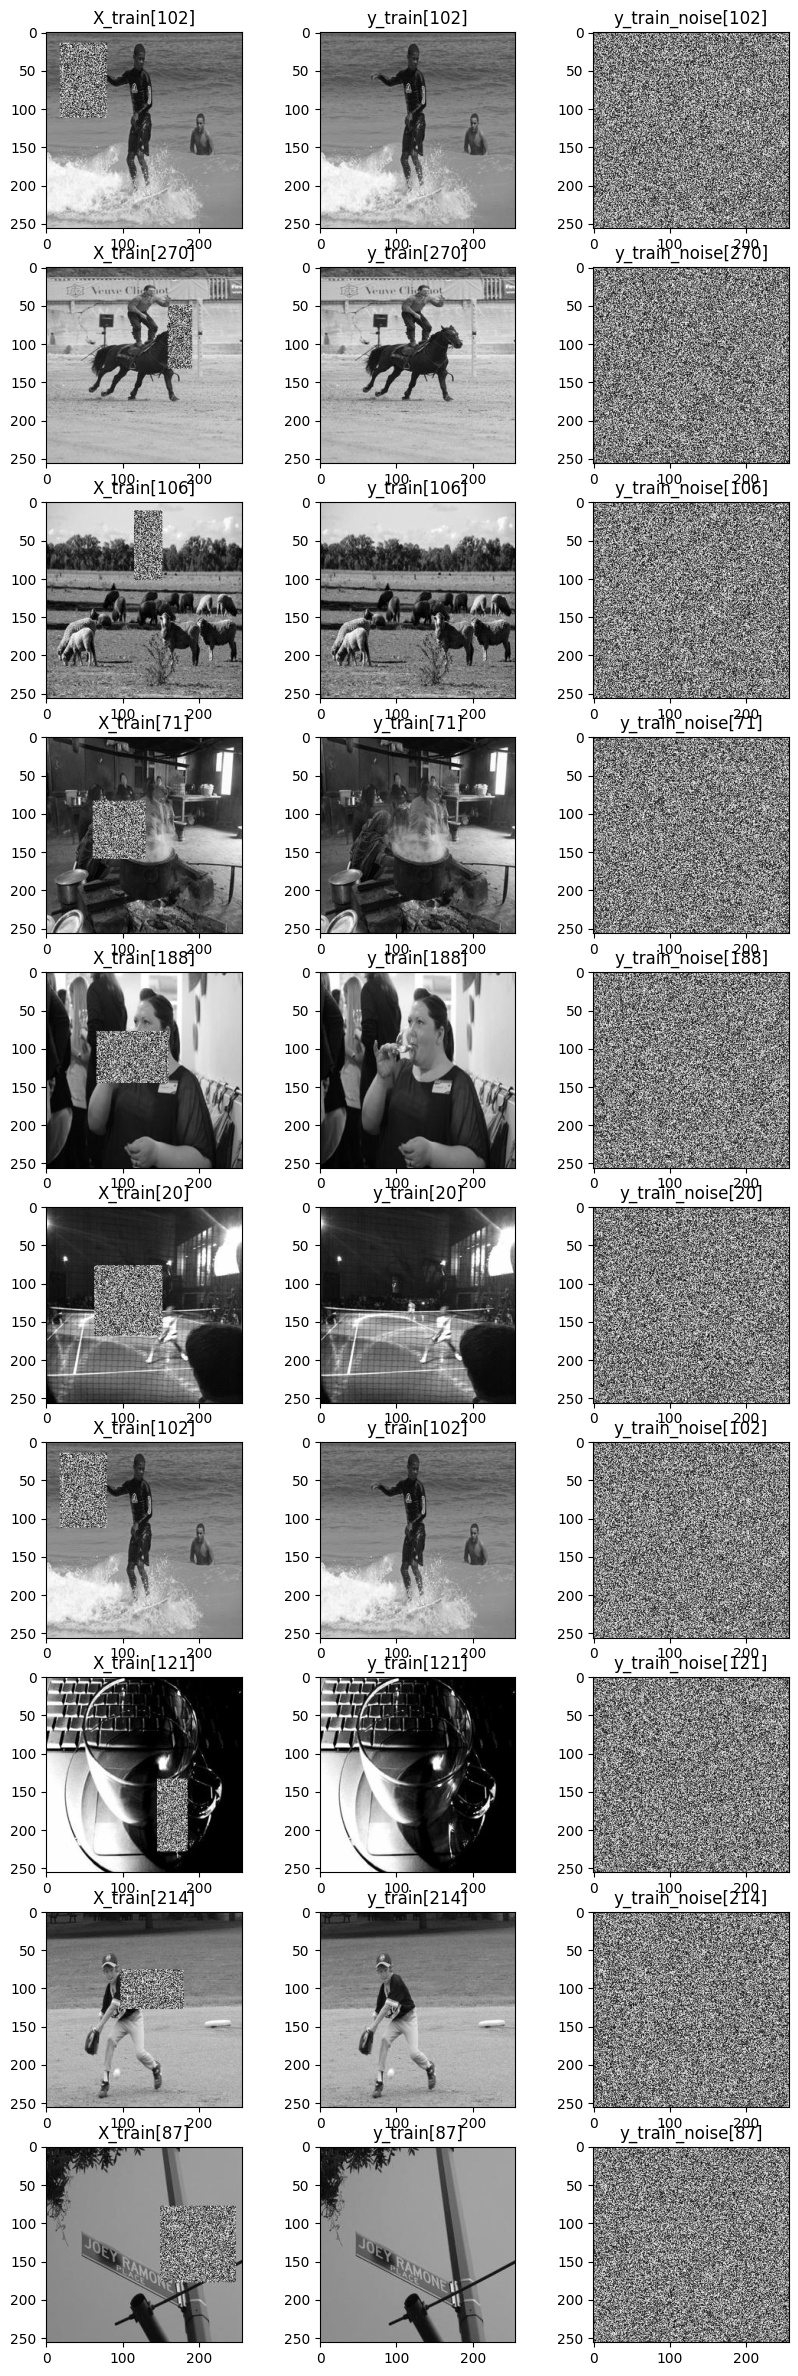

In [ ]:
randlist = np.random.randint(0, X_train.shape[0], 10)

ax, fig = plt.subplots(10, 3, figsize=(10, 30))
for i, j in zip(range(10), randlist):
    fig[i][0].title.set_text(f"X_train[{j}]")
    fig[i][1].title.set_text(f"y_train[{j}]")
    fig[i][2].title.set_text(f"y_train_noise[{j}]")
    fig[i][0].imshow(X_train[j], cmap='gray')
    fig[i][1].imshow(y_train[j], cmap='gray')
    fig[i][2].imshow(y_train_noise[j], cmap='gray')
plt.show()

# Modeling

In [ ]:
input_layer = layers.Input(shape=(X_train.shape[1], X_train.shape[2], 1))

# Encoder
x1 = layers.Conv2D(8, (2, 2), strides=2, padding='same', activation='relu')(input_layer)
x1 = layers.LayerNormalization()(x1)
attention_output = layers.MultiHeadAttention(num_heads=32, key_dim=32)(x1, x1)
x1 = layers.Add()([attention_output, x1])
x1 = layers.LayerNormalization()(x1)
# x1 = layers.Dense(128)(x1)
# x1 = layers.Dense(64)(x1)

y1 = x1

encoder = keras.Model(inputs=input_layer, outputs=y1, name="encoder")
encoder.summary()

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 8)          40        ['input_1[0][0]']             
                                                                                                  
 layer_normalization (Layer  (None, 128, 128, 8)          16        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 multi_head_att

In [ ]:
input_layer = layers.Input(shape=(128, 128, 8))

# Decoder
x1 = layers.Dense(128)(input_layer)
attention_output = layers.MultiHeadAttention(num_heads=32, key_dim=32)(x1, x1)
x1 = layers.Add()([attention_output, x1])
x1 = layers.LayerNormalization()(x1)

x1 = layers.Conv2DTranspose(1, (2, 2), strides=2, padding='same', activation='relu')(x1)
x1 = layers.LayerNormalization()(x1)

y1 = x1

decoder = keras.Model(inputs=input_layer, outputs=y1, name="decoder")
decoder.summary()

Model: "decoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 8)]        0         []                            
                                                                                                  
 dense (Dense)               (None, 128, 128, 128)        1152      ['input_2[0][0]']             
                                                                                                  
 multi_head_attention_1 (Mu  (None, 128, 128, 128)        527488    ['dense[0][0]',               
 ltiHeadAttention)                                                   'dense[0][0]']               
                                                                                                  
 add_1 (Add)                 (None, 128, 128, 128)        0         ['multi_head_attention_1

In [ ]:
model = keras.Model(inputs=encoder.input, outputs=decoder(encoder.output), name="autoencoder")
model.summary()

Model: "autoencoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 8)          40        ['input_1[0][0]']             
                                                                                                  
 layer_normalization (Layer  (None, 128, 128, 8)          16        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 multi_head_attention (Mult  (None, 128, 128, 8)          35848     ['layer_normalizatio

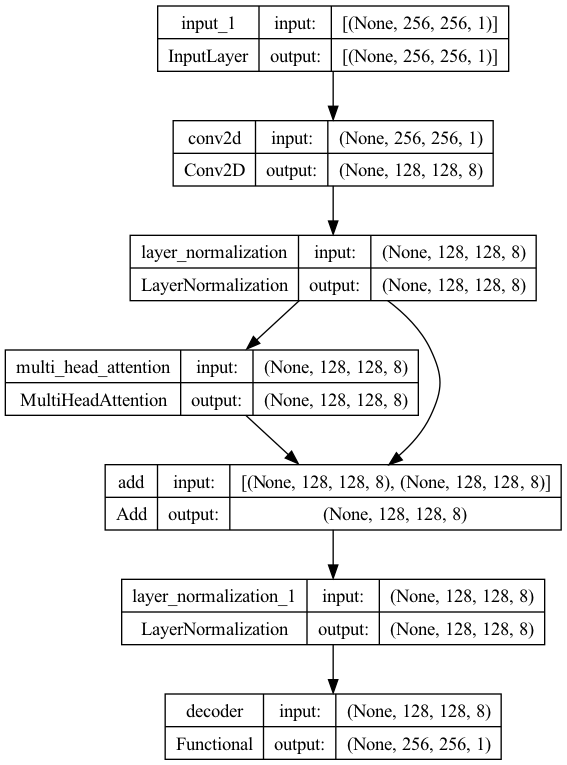

In [ ]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
optimzier = tf.keras.optimizers.Adam(learning_rate=0.003)
loss = tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer=optimzier, loss=[loss, loss], metrics=['accuracy'])

# Model Training

In [ ]:
outDir = './checkpoint_attention/' # 이 경로에 best 모델이 저장된다.
model_names = outDir + 'weights-{epoch}-{val_noise_image_loss:.8f}-{val_reconstructed_image_loss:.8f}.h5'
def get_callbacks(patience = 50):
    model_checkpoint = ModelCheckpoint(model_names, monitor='val_reconstructed_image_loss', verbose=1, save_best_only=True, period = 1)
    callbacks = [model_checkpoint]
    return callbacks

callback = get_callbacks()

In [ ]:
history = model.fit(
    y_train, y_train,
    epochs=50,
    batch_size=16,
    validation_data=(y_test, y_test),
    callbacks=[callback]
)

Epoch 1/50


# Result

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(train_loss, 'r', label='train loss')
plt.plot(val_loss, 'b', label='val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
y_pred[0].shape

In [ ]:
plt.figure(figsize=(20, 4))
for i in range(10):
    # display reconstruction
    ax = plt.subplot(2, 10, i + 1 + 10)
    plt.imshow(y_pred[0][i].reshape(256, 256))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display input image
    ax = plt.subplot(2, 10, i + 1)
    plt.imshow(y_test[i].reshape(256, 256))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Model Evaluation

In [ ]:
trained_model_path = sorted(os.listdir(outDir))
pretrained_model_file = outDir + "weights-37-0.69992024-0.59163594.h5"
print(f"pretrained_model_file: {pretrained_model_file}")

pretrained_model = keras.models.load_model(pretrained_model_file)

In [ ]:
y_pred = pretrained_model.predict(X_test)

In [ ]:
print(f"""y_pred shape: {y_pred[0].shape}
y_test shape: {y_test.shape}""")

In [ ]:
IMAGE_SELECT = 23

fig, ax = plt.subplots(1, 3, figsize=(20, 10))
ax[0].imshow(X_test[IMAGE_SELECT])
ax[0].set_title('Input Image')
ax[1].imshow(y_pred[0][IMAGE_SELECT])
ax[1].set_title('Predicted Image')
ax[2].imshow(y_test[IMAGE_SELECT])
ax[2].set_title('Ground Truth Image')
plt.show()